## Adaptive RAG Revenue details and Share price

In [24]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


urls=[
    "https://www.microsoft.com/investor/reports/ar24/index.html/",
    "https://www.microsoft.com/en-us/investor/earnings/fy-2024-q4/segment-revenues/",
    "https://www.investopedia.com/how-microsoft-makes-money-4798809/"
]
docs=[WebBaseLoader(url).load() for url in urls]
docs


USER_AGENT environment variable not set, consider setting it to identify your requests.


[[Document(metadata={'source': 'https://www.microsoft.com/investor/reports/ar24/index.html/'}, page_content='The resource you are looking for has been removed, had its name changed, or is temporarily unavailable.')],
 [Document(metadata={'source': 'https://www.microsoft.com/en-us/investor/earnings/fy-2024-q4/segment-revenues/', 'title': 'FY24 Q4 - Segment Revenue and Operating Income - Investor Relations - Microsoft', 'language': 'en-US'}, page_content="\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFY24 Q4 - Segment Revenue and Operating Income - Investor Relations - Microsoft\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\t\t\t\n\n\t\t\n\t\t\n\t\t\t\tThis is the Trace Id: a1c8783dbe6708355e621b4b4857bbad\n\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to main content\n\n\n\n\n\n\n\nMicrosoft\n\n\n\nInvestor Relations\n\n\n\n\nInvestor Relations\n\n\n\n\n     

In [3]:
doc_list=[item for sublist in docs for item in sublist]
doc_list

[Document(metadata={'source': 'https://www.microsoft.com/investor/reports/ar24/index.html/'}, page_content='The resource you are looking for has been removed, had its name changed, or is temporarily unavailable.'),
 Document(metadata={'source': 'https://www.microsoft.com/en-us/investor/earnings/fy-2024-q4/segment-revenues/', 'title': 'FY24 Q4 - Segment Revenue and Operating Income - Investor Relations - Microsoft', 'language': 'en-US'}, page_content="\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFY24 Q4 - Segment Revenue and Operating Income - Investor Relations - Microsoft\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\t\t\t\n\n\t\t\n\t\t\n\t\t\t\tThis is the Trace Id: a1c8783dbe6708355e621b4b4857bbad\n\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to main content\n\n\n\n\n\n\n\nMicrosoft\n\n\n\nInvestor Relations\n\n\n\n\nInvestor Relations\n\n\n\n\n        

In [4]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,chunk_overlap=100
)

doc_split=text_splitter.split_documents(doc_list)

#Add to VectorDB
vectorstore=FAISS.from_documents(
    documents=doc_split,
    embedding=OpenAIEmbeddings()
)
retriever=vectorstore.as_retriever()

In [5]:
retriever.invoke("microsoft revenue detail")

[Document(id='6a9eef95-252d-4774-96b2-a049c39efae8', metadata={'source': 'https://www.investopedia.com/how-microsoft-makes-money-4798809/', 'title': 'How Microsoft Makes Money', 'description': "Microsoft's is committed to responsibly designed AI. Its Intelligent Cloud segment is growing fast and is the largest source of the company's revenue and profit.", 'language': 'en'}, page_content='For the third quarter of FY 2024, revenue was $19.6 billion, an increase of 12% over the same period the previous year. It was driven by Dynamics products and cloud services which increased 19%. Operating income for the quarter was $10.1 billion, up about 17%.\n\n\n Intelligent Cloud\n\n\n The Intelligent Cloud segment is comprised of all of Microsoft\'s public, private, and hybrid server products as well as cloud services for business. These include Microsoft Azure, SQL Server, Windows Server, GitHub, Enterprise Services, and more.\n\n\n For FY 2023, Intelligent Cloud generated $87.9 billion in revenu

In [6]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

# Data Model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource"""
    
    datasource:Literal["vectorstore","web_search"]=Field(
        description="Given a user question choose to route it to web search or a vectorstore."
    )

# LLM with function call
llm=ChatOpenAI(model="gpt-4o-mini",temperature=0)
structured_llm_router=llm.with_structured_output(RouteQuery)


#Prompt
system="""You are an finance expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to Microsoft Revenue ,Satya Nadella microsoft CEO shareholder 2024 letter,revenue 
distributtion of microsoft.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

route_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",system),
        ("human","{question}"),
    ]
)

question_router=route_prompt|structured_llm_router

print(question_router.invoke({"question":"What is microsoft current_stock price?"}))

datasource='web_search'


In [7]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "microsoft revenue"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [9]:
docs

[Document(id='6a9eef95-252d-4774-96b2-a049c39efae8', metadata={'source': 'https://www.investopedia.com/how-microsoft-makes-money-4798809/', 'title': 'How Microsoft Makes Money', 'description': "Microsoft's is committed to responsibly designed AI. Its Intelligent Cloud segment is growing fast and is the largest source of the company's revenue and profit.", 'language': 'en'}, page_content='For the third quarter of FY 2024, revenue was $19.6 billion, an increase of 12% over the same period the previous year. It was driven by Dynamics products and cloud services which increased 19%. Operating income for the quarter was $10.1 billion, up about 17%.\n\n\n Intelligent Cloud\n\n\n The Intelligent Cloud segment is comprised of all of Microsoft\'s public, private, and hybrid server products as well as cloud services for business. These include Microsoft Azure, SQL Server, Windows Server, GitHub, Enterprise Services, and more.\n\n\n For FY 2023, Intelligent Cloud generated $87.9 billion in revenu

In [14]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser
question = "microsoft revenue 2023"

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In FY 2023, Microsoft's total revenue was $211.91 billion, which represents a 7% increase from the previous year. The Intelligent Cloud segment generated $87.9 billion, while the More Personal Computing segment brought in $54.7 billion. Overall, the company experienced growth across its various business segments.


In [15]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [12]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [16]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
 
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

"What is Microsoft's revenue for the year 2023?"

In [28]:
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool=TavilySearchResults(k=3)

In [29]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [30]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [31]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

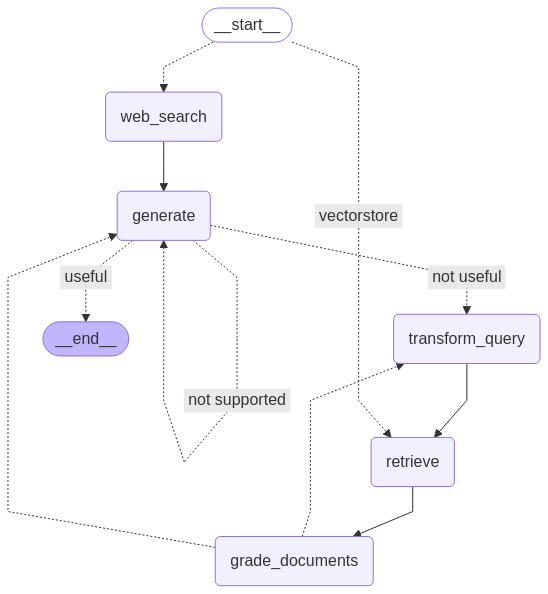

In [32]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
from pprint import pprint

# Run
inputs = {
    "question": "In which  area microsoft is making more money?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Microsoft is making the most money in its Intelligent Cloud segment, which '
 "is the largest source of the company's revenue and profit. For FY 2023, this "
 'segment generated $87.9 billion in revenue, reflecting a 17% increase from '
 'the previous year. The growth is driven by services like Microsoft Azure and '
 'other cloud offerings.')


In [34]:
from pprint import pprint

# Run
inputs = {
    "question": "What is microsoft investing in 2025?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('In 2025, Microsoft plans to invest approximately $80 billion in AI-enabled '
 'data centers to train AI models and deploy cloud-based applications '
 'globally. More than half of this investment will be directed toward the '
 "United States, reflecting the company's commitment to the American economy. "
 "This initiative is part of Microsoft's broader vision to advance AI "
 'technology and infrastructure.')
